<a href="https://colab.research.google.com/github/rybinsky/House-Price-Prediction/blob/main/version2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [237]:
import warnings 
warnings.filterwarnings('ignore')

# Pandas and numpy for data manipulation
import pandas as pd
import numpy as np
import copy

# No warnings about setting value on copy of slice
pd.options.mode.chained_assignment = None

# Display up to 60 columns of a dataframe
pd.set_option('display.max_columns', 60)

# Matplotlib visualization
import matplotlib.pyplot as plt

# Internal ipython tool for setting figure size
from IPython.core.pylabtools import figsize

# Seaborn for visualization
import seaborn as sns
#sns.set(font_scale = 2)
# Splitting data into training and testing
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, \
                                    RandomForestRegressor, GradientBoostingRegressor

In [238]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
train_df.head(10)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,...,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,...,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,...,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,...,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,...,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,...,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1.5Fin,5,5,1993,1995,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,Wood,...,1,1,TA,5,Typ,0,NaN,Attchd,1993.0,Unf,2,480,TA,TA,Y,40,30,0,320,0,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,1Story,8,5,2004,2005,Gable,CompShg,VinylSd,VinylSd,Stone,186.0,Gd,TA,PConc,...,3,1,Gd,7,Typ,1,Gd,Attchd,2004.0,RFn,2,636,TA,TA,Y,255,57,0,0,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal,307000
7,8,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NWAmes,PosN,Norm,1Fam,2Story,7,6,1973,1973,Gable,CompShg,HdBoard,HdBoard,Stone,240.0,TA,TA,CBlock,...,3,1,TA,7,Typ,2,TA,Attchd,1973.0,RFn,2,484,TA,TA,Y,235,204,228,0,0,0,NaN,NaN,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Artery,Norm,1Fam,1.5Fin,7,5,1931,1950,Gable,CompShg,BrkFace,Wd Shng,None,0.0,TA,TA,BrkTil,...,2,2,TA,8,Min1,2,TA,Detchd,1931.0,Unf,2,468,Fa,TA,Y,90,0,205,0,0,0,NaN,NaN,NaN,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.0,7420,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,BrkSide,Artery,Artery,2fmCon,1.5Unf,5,6,1939,1950,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,BrkTil,...,2,2,TA,5,Typ,2,TA,Attchd,1939.0,RFn,1,205,Gd,TA,Y,0,4,0,0,0,0,NaN,NaN,NaN,0,1,2008,WD,Normal,118000


In [239]:
continuous_columns = [key for key in train_df.keys() if train_df[key].dtype in ("int64", "float64")]
categorical_columns = [key for key in train_df.keys() if train_df[key].dtype == "object"]

# Предобработка

In [240]:
history = {}

In [241]:
history['default'] = copy.deepcopy(train_df)

In [242]:
# Function to calculate missing values by column
def missing_values_table(df):
    '''
    Description:
        Функция вычисляет процент пропущенных значений в каждом столбце
    Args:
        df (pd.DataFrame): матрица признаков
    Returns:
        mis_val_table_ren_columns (pd.DataFrame): матрица информации
    '''
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    # Make a table with the results
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis = 1)
    # Rename the columns
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values'})
    # Sort the table by percentage of missing descending
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:, 1] != 0].sort_values(
        '% of Total Values', ascending = False).round(1)
        
    # Print some summary information
    print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
      
    return mis_val_table_ren_columns

In [243]:
missing_values_table(train_df)

Your selected dataframe has 81 columns.
There are 19 columns that have missing values.


,Missing Values,% of Total Values
PoolQC,1453,99.5
MiscFeature,1406,96.3
Alley,1369,93.8
Fence,1179,80.8
FireplaceQu,690,47.3
LotFrontage,259,17.7
GarageType,81,5.5
GarageYrBlt,81,5.5
GarageFinish,81,5.5
GarageQual,81,5.5


In [244]:
missing_df = missing_values_table(train_df)
missing_columns = list(missing_df[missing_df['% of Total Values'] > 50].index)
print('We will remove %d columns.' % len(missing_columns))

# Drop the columns
train_df = train_df.drop(columns = list(missing_columns))
# Also in test
test_df = test_df.drop(columns = list(missing_columns))

Your selected dataframe has 81 columns.
There are 19 columns that have missing values.
We will remove 4 columns.


In [245]:
train_df.describe(include = 'all')

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,...,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
count,1460.000000,1460.000000,1460,1201.000000,1460.000000,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460.000000,1460.000000,1460.000000,1460.000000,1460,1460,1460,1460,1452,1452.000000,1460,1460,1460,1423,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460,1460.000000,1460,1460.000000,770,1379,1379.000000,1379,1460.000000,1460.000000,1379,1379,1460,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460,1460,1460.000000
unique,NaN,NaN,5,NaN,NaN,2,4,4,2,5,3,25,9,8,5,8,NaN,NaN,NaN,NaN,6,8,15,16,4,NaN,4,5,6,4,...,NaN,NaN,NaN,NaN,NaN,4,NaN,7,NaN,5,6,NaN,3,NaN,NaN,5,5,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9,6,NaN
top,NaN,NaN,RL,NaN,NaN,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,NaN,NaN,NaN,NaN,Gable,CompShg,VinylSd,VinylSd,None,NaN,TA,TA,PConc,TA,...,NaN,NaN,NaN,NaN,NaN,TA,NaN,Typ,NaN,Gd,Attchd,NaN,Unf,NaN,NaN,TA,TA,Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,WD,Normal,NaN
freq,NaN,NaN,1151,NaN,NaN,1454,925,1311,1459,1052,1382,225,1260,1445,1220,726,NaN,NaN,NaN,NaN,1141,1434,515,504,864,NaN,906,1282,647,649,...,NaN,NaN,NaN,NaN,NaN,735,NaN,1360,NaN,380,870,NaN,605,NaN,NaN,1311,1326,1340,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1267,1198,NaN
mean,730.500000,56.897260,NaN,70.049958,10516.828082,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.099315,5.575342,1971.267808,1984.865753,NaN,NaN,NaN,NaN,NaN,103.685262,NaN,NaN,NaN,NaN,...,0.057534,1.565068,0.382877,2.866438,1.046575,NaN,6.517808,NaN,0.613014,NaN,NaN,1978.506164,NaN,1.767123,472.980137,NaN,NaN,NaN,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,NaN,NaN,180921.195890
std,421.610009,42.300571,NaN,24.284752,9981.264932,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.382997,1.112799,30.202904,20.645407,NaN,NaN,NaN,NaN,NaN,181.066207,NaN,NaN,NaN,NaN,...,0.238753,0.550916,0.502885,0.815778,0.220338,NaN,1.625393,NaN,0.644666,NaN,NaN,24.689725,NaN,0.747315,213.804841,NaN,NaN,NaN,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,NaN,NaN,79442.502883
min,1.000000,20.000000,NaN,21.000000,1300.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,1.000000,1872.000000,1950.000000,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,2.000000,NaN,0.000000,NaN,NaN,1900.000000,NaN,0.000000,0.000000,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,NaN,NaN,34900.000000
25%,365.750000,20.000000,NaN,59.000000,7553.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.000000,5.000000,1954.000000,1967.000000,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,...,0.000000,1.000000,0.000000,2.000000,1.000000,NaN,5.000000,NaN,0.000000,NaN,NaN,1961.000000,NaN,1.000000,334.500000,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,NaN,NaN,129975.000000
50%,730.500000,50.000000,NaN,69.000000,9478.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.000000,5.000000,1973.000000,1994.000000,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,...,0.000000,2.000000,0.000000,3.000000,1.000000,NaN,6.000000,NaN,1.000000,NaN,NaN,1980.000000,NaN,2.000000,480.000000,NaN,NaN,NaN,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,NaN,NaN,163000.000000
75%,1095.2

In [246]:
def print_missing_percent(df, threshold):
    '''
    Description:
        Выводит все поля, где пропущен какой-то процент значений

    Args:
        df (pd.DataFrame): матрица признаков
        threshold (float): порог отсечения между автозаполненными признаками и нет

    Returns:
        missing_list (list): массив пропущенных значений меньше порога threshold
    '''
    missing_list = []
    for col in df.columns:
        missing_count = df[col].isna().sum()
        total_count = df[col].count() + missing_count
        missing_percent = missing_count / total_count * 100
        if missing_percent:
            if missing_percent < threshold:
                missing_list.append(col)
            print(f"Column {col}: {missing_percent:.2f}%   missing values,  type: {df[col].dtype}")
    return missing_list

missing_list_train = print_missing_percent(df = train_df, threshold = 10)
print('#==================================================================#')
missing_list_test = print_missing_percent(df = test_df, threshold = 10)

Column LotFrontage: 17.74%   missing values,  type: float64
Column MasVnrType: 0.55%   missing values,  type: object
Column MasVnrArea: 0.55%   missing values,  type: float64
Column BsmtQual: 2.53%   missing values,  type: object
Column BsmtCond: 2.53%   missing values,  type: object
Column BsmtExposure: 2.60%   missing values,  type: object
Column BsmtFinType1: 2.53%   missing values,  type: object
Column BsmtFinType2: 2.60%   missing values,  type: object
Column Electrical: 0.07%   missing values,  type: object
Column FireplaceQu: 47.26%   missing values,  type: object
Column GarageType: 5.55%   missing values,  type: object
Column GarageYrBlt: 5.55%   missing values,  type: float64
Column GarageFinish: 5.55%   missing values,  type: object
Column GarageQual: 5.55%   missing values,  type: object
Column GarageCond: 5.55%   missing values,  type: object
#==================================================================#
Column MSZoning: 0.27%   missing values,  type: object
Column Lo

Теперь везде где мало значений заполним простым методом, а где много обучим модели для заполнения. Напишем функцию для заполнения там где мало пропущенных данных 

In [247]:
def fill_missing_auto(df, mis_list):
    '''
    Description:
        Заполняет пропуски из df в колонках mis_list определенным методом
    Args:
        df (pd.DataFrame): матрица признаков
        mis_list (list): колонки, подлежащие заполнению 
    '''
    for col in mis_list:
        if df[col].dtype in ("int64", "float64"):
            df[col].fillna(df[col].mean(), inplace = True) # среднее для численных
        else:
            most_common_value = df[col].mode()[0] # самый частый для категориальных
            df[col].fillna(most_common_value, inplace = True)

fill_missing_auto(train_df, missing_list_train)
fill_missing_auto(test_df, missing_list_test)

In [248]:
print_missing_percent(df = train_df, threshold = 10)
print('#==================================================================#')
print_missing_percent(df = test_df, threshold = 10);

Column LotFrontage: 17.74%   missing values,  type: float64
Column FireplaceQu: 47.26%   missing values,  type: object
#==================================================================#
Column LotFrontage: 15.56%   missing values,  type: float64
Column FireplaceQu: 50.03%   missing values,  type: object


Посмотрим на эти признаки, где достаточно много пропущенных значений. Для этого будем обучать модели, но сначала надо разобраться с корреллируемыми признаками


In [249]:
def remove_collinear_features(df, threshold, verbose, target_var):
    '''
    Description:
        Удаляет зависимые признаки из матрицы с коэффициентом корреллции больше порога threshold 
        и у которых практически отсутствует коррелляция с таргетом
        Такая процедура улучшает обощающую способность и повышает интерпретируемость модели

    Args: 
        df (pd.DataFrame): матрица признаков
        threshold (float): порог отсечения признаков
        verbose (bool): если True, то печатаем лог
        target_var (str): таргет - имя колонки, некорреллируемые с которой признаки удаляем

    Returns: 
        df (pd.DataFrame): матрица, очищенная от зависимых признаков
    '''
    # Вычислим матрицу коррелляций
    corr_matrix = df.drop(target_var, 1).corr()
    iters = range(len(corr_matrix.columns) - 1)
    drop_cols = []
    dropped_feature = ""

    # Итерируемся по ней и сравниваем попарные коррелляции
    for i in iters:
        for j in range(i + 1): 
            item = corr_matrix.iloc[j: (j + 1), (i + 1): (i + 2)]
            col = item.columns
            row = item.index
            val = abs(item.values)

            if val >= threshold:
                if verbose:
                    print(col.values[0], "|", row.values[0], "|", round(val[0][0], 2))
                col_value_corr = df[col.values[0]].corr(df[target_var])
                row_value_corr = df[row.values[0]].corr(df[target_var])
                if verbose:
                    print("{}: {}".format(col.values[0], np.round(col_value_corr, 3)))
                    print("{}: {}".format(row.values[0], np.round(row_value_corr, 3)))
                if col_value_corr < row_value_corr:
                    drop_cols.append(col.values[0])
                    dropped_feature = "dropped: " + col.values[0]
                else:
                    drop_cols.append(row.values[0])
                    dropped_feature = "dropped: " + row.values[0]
                if verbose:
                    print(dropped_feature)
                    print("-----------------------------------------------------------------------------")

    # Выбросим одну из достаточно корреллируемых колонок
    drops = set(drop_cols)
    df = df.drop(columns = drops)

    print("dropped columns: ")
    print(list(drops))
    print("-----------------------------------------------------------------------------")
    print("used columns: ")
    print(df.columns.tolist())
    
    return df, drops

In [250]:
continuous_columns = [key for key in train_df.keys() if train_df[key].dtype in ("int64", "float64")]
categorical_columns = [key for key in train_df.keys() if train_df[key].dtype == "object"]

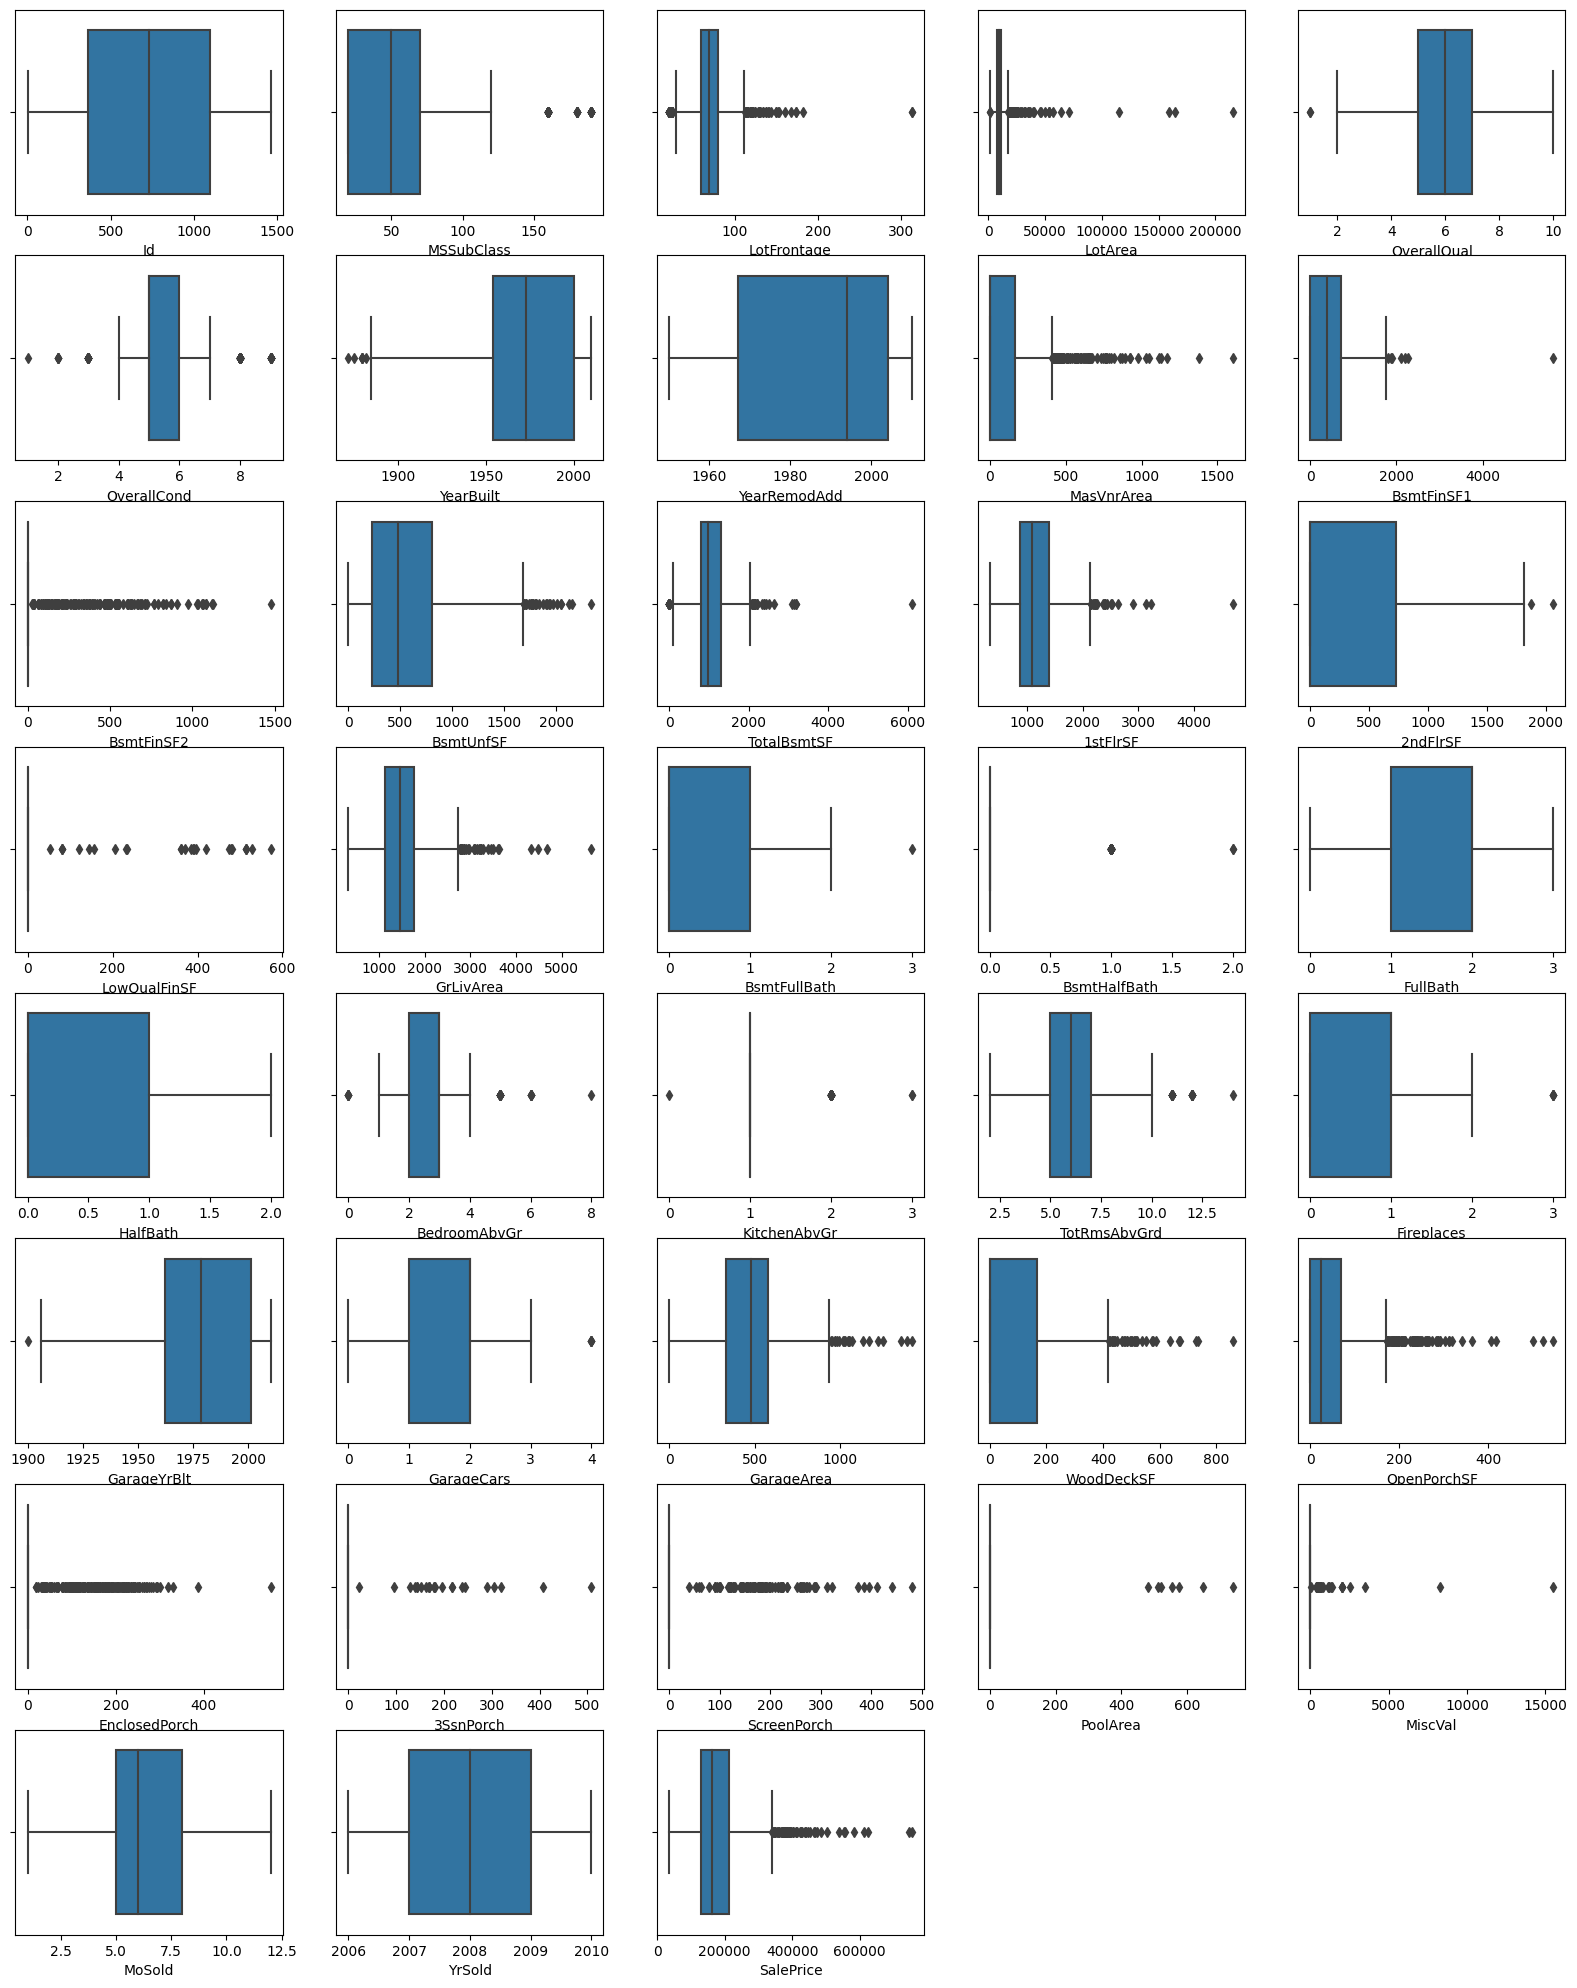

In [251]:
plt.figure(figsize = (20, 25))
for i, col in enumerate(continuous_columns):
    plt.subplot(8, 5, i + 1)
    sns.boxplot(data = train_df, x = train_df[col])

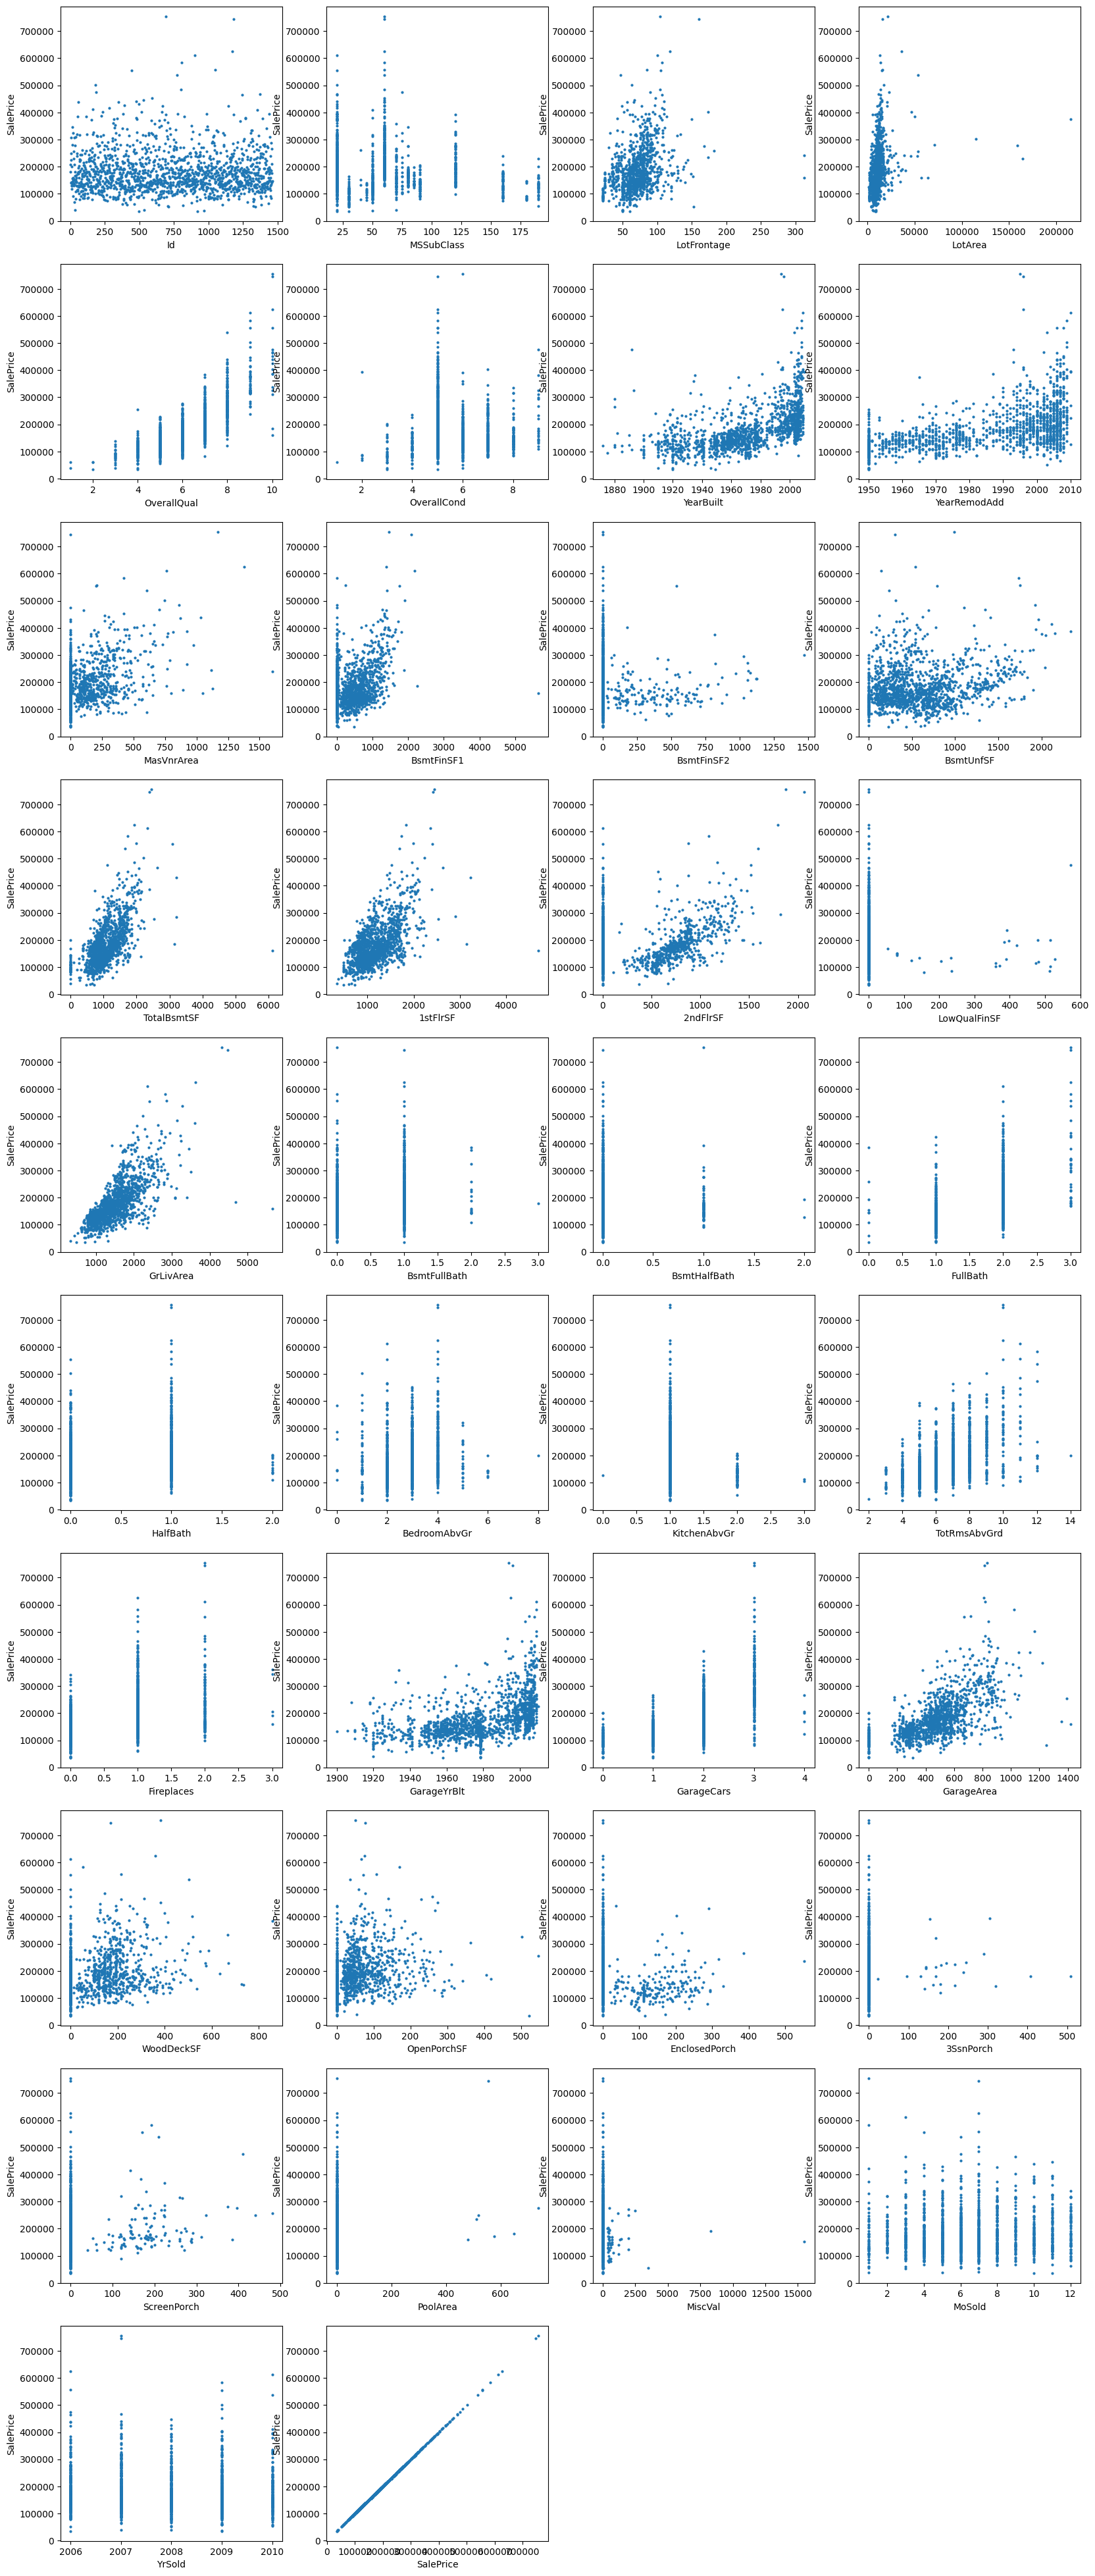

In [252]:
plt.figure(figsize = (20, 50))

for i, col in enumerate(continuous_columns):
    plt.subplot(10, 4, i + 1)
    plt.scatter(train_df[col], train_df.SalePrice, s = 4)
    plt.xlabel(col)
    plt.ylabel('SalePrice')

plt.show()      

In [253]:
def drop_similar_columns(df, threshold):
    '''
    Description:
        Удаляет столбцы из df, если в них больше, чем threshold одинаковых значений

    Args:
        df (pd.DataFrame): матрица признаков
        threshold (float): порог удаления

    Returns:
        df (pd.DataFrame): очищенная матрица признаков
        drop_cols (list): удаляемые колонки
    '''
    num_rows = df.shape[0]
    drop_cols = []
    
    for col in df.columns:
        if df[col].value_counts().iloc[0] >= num_rows * (threshold / 100):
            drop_cols.append(col)

    df = df.drop(columns = drop_cols)
    print(drop_cols)
    return df

In [254]:
train_df = drop_similar_columns(train_df, threshold = 97.5)

['Street', 'Utilities', 'Condition2', 'RoofMatl', 'Heating', 'LowQualFinSF', '3SsnPorch', 'PoolArea']


In [255]:
train_df.drop(columns = ['Id'], inplace = True)

In [256]:
continuous_columns = [key for key in train_df.keys() if train_df[key].dtype in ("int64", "float64")]
categorical_columns = [key for key in train_df.keys() if train_df[key].dtype == "object"]

In [257]:
categorical_columns

['MSZoning',
 'LotShape',
 'LandContour',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'KitchenQual',
 'Functional',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'SaleType',
 'SaleCondition']

Качественные колонки:

  - ExterQual (Ex Gd TA Fa Po)
  - ExterCond (Ex Gd TA Fa Po)
  - BsmtQual (Ex Gd TA Fa Po NA)
  - BsmtCond (Ex Gd TA Fa Po NA) 
  - HeatingQC (Ex Gd TA Fa Po)
  - KitchenQual (Ex Gd TA Fa Po)
  - FireplaceQu (Ex Gd TA Fa Po NA)
  - GarageQual (Ex Gd TA Fa Po)
  - GarageCond (Ex Gd TA Fa Po)
  - PoolQC (Ex Gd TA Fa Po)



Нужно заполнить LotFrontage и FireplaseQu

In [259]:
qual_columns = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond', 'PoolQC']

In [260]:
changer = {
    'Ex' : 5,
    'Gd' : 4,
    'TA' : 3,
    'Fa' : 2, 
    'Po' : 1,
    'NA' : 0
}

In [261]:
for col in qual_columns:
    if col in train_df.columns:
        train_df[col] = train_df[col].map(changer)
    if col in test_df.columns:
        test_df[col] = test_df[col].map(changer)

In [262]:
continuous_columns = [key for key in train_df.keys() if train_df[key].dtype in ("int64", "float64")]
categorical_columns = [key for key in train_df.keys() if train_df[key].dtype == "object"]

In [263]:
categorical_columns

['MSZoning',
 'LotShape',
 'LandContour',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'Foundation',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'CentralAir',
 'Electrical',
 'Functional',
 'GarageType',
 'GarageFinish',
 'PavedDrive',
 'SaleType',
 'SaleCondition']

In [264]:
for col in categorical_columns:
    print(f"Количество значений в колонке <{col}>:")
    print(train_df[col].value_counts())
    print('#============================================#')

Количество значений в колонке <MSZoning>:
RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64
#============================================#
Количество значений в колонке <LotShape>:
Reg    925
IR1    484
IR2     41
IR3     10
Name: LotShape, dtype: int64
#============================================#
Количество значений в колонке <LandContour>:
Lvl    1311
Bnk      63
HLS      50
Low      36
Name: LandContour, dtype: int64
#============================================#
Количество значений в колонке <LotConfig>:
Inside     1052
Corner      263
CulDSac      94
FR2          47
FR3           4
Name: LotConfig, dtype: int64
#============================================#
Количество значений в колонке <LandSlope>:
Gtl    1382
Mod      65
Sev      13
Name: LandSlope, dtype: int64
#============================================#
Количество значений в колонке <Neighborhood>:
NAmes      225
CollgCr    150
OldTown    113
Edwards    100
Somers

In [265]:
test_df = drop_similar_columns(test_df, threshold = 97.5)

['Street', 'Utilities', 'Condition2', 'RoofMatl', 'Heating', 'LowQualFinSF', '3SsnPorch', 'PoolArea']


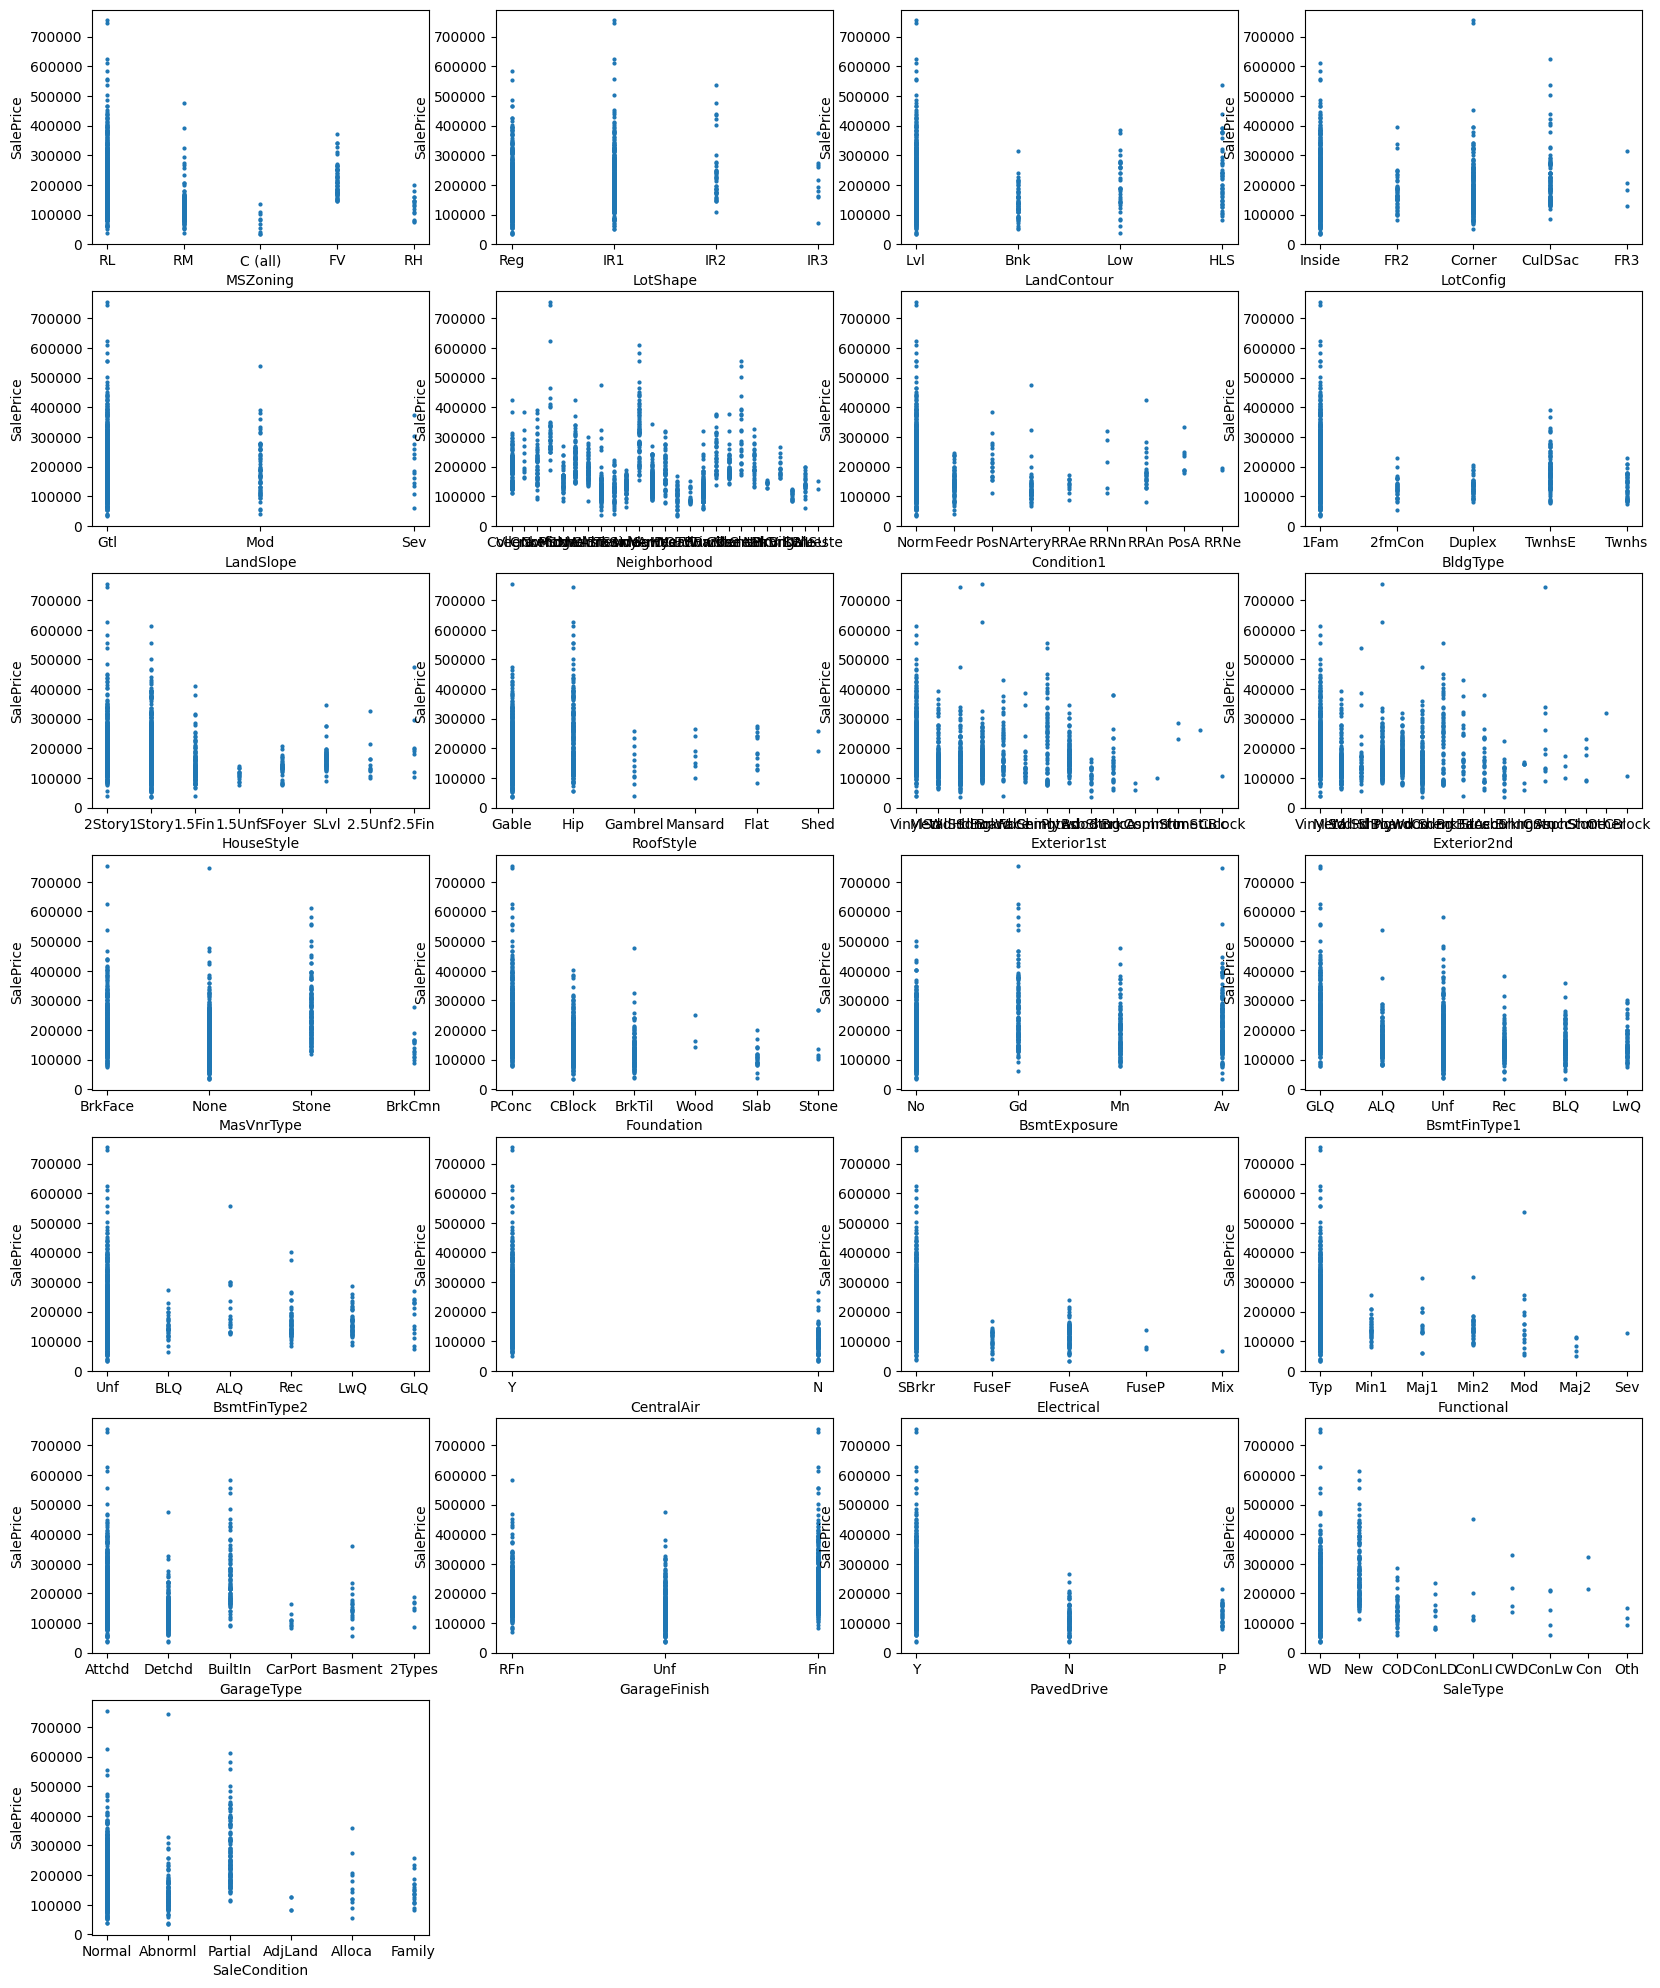

In [266]:
plt.figure(figsize = (20, 25))

for i, col in enumerate(categorical_columns):
    plt.subplot(7, 4, i + 1)
    plt.scatter(train_df[col], train_df.SalePrice, s = 4)
    plt.xlabel(col)
    plt.ylabel('SalePrice')

plt.show()    

Также есть колонки, которые не просто категориальные. Но это потом, там не так просто

 - MasVnrType
 - Foundation
 - BsmtExposure
 - BsmtFinType1

In [267]:
test_df['SalePrice'] = 0

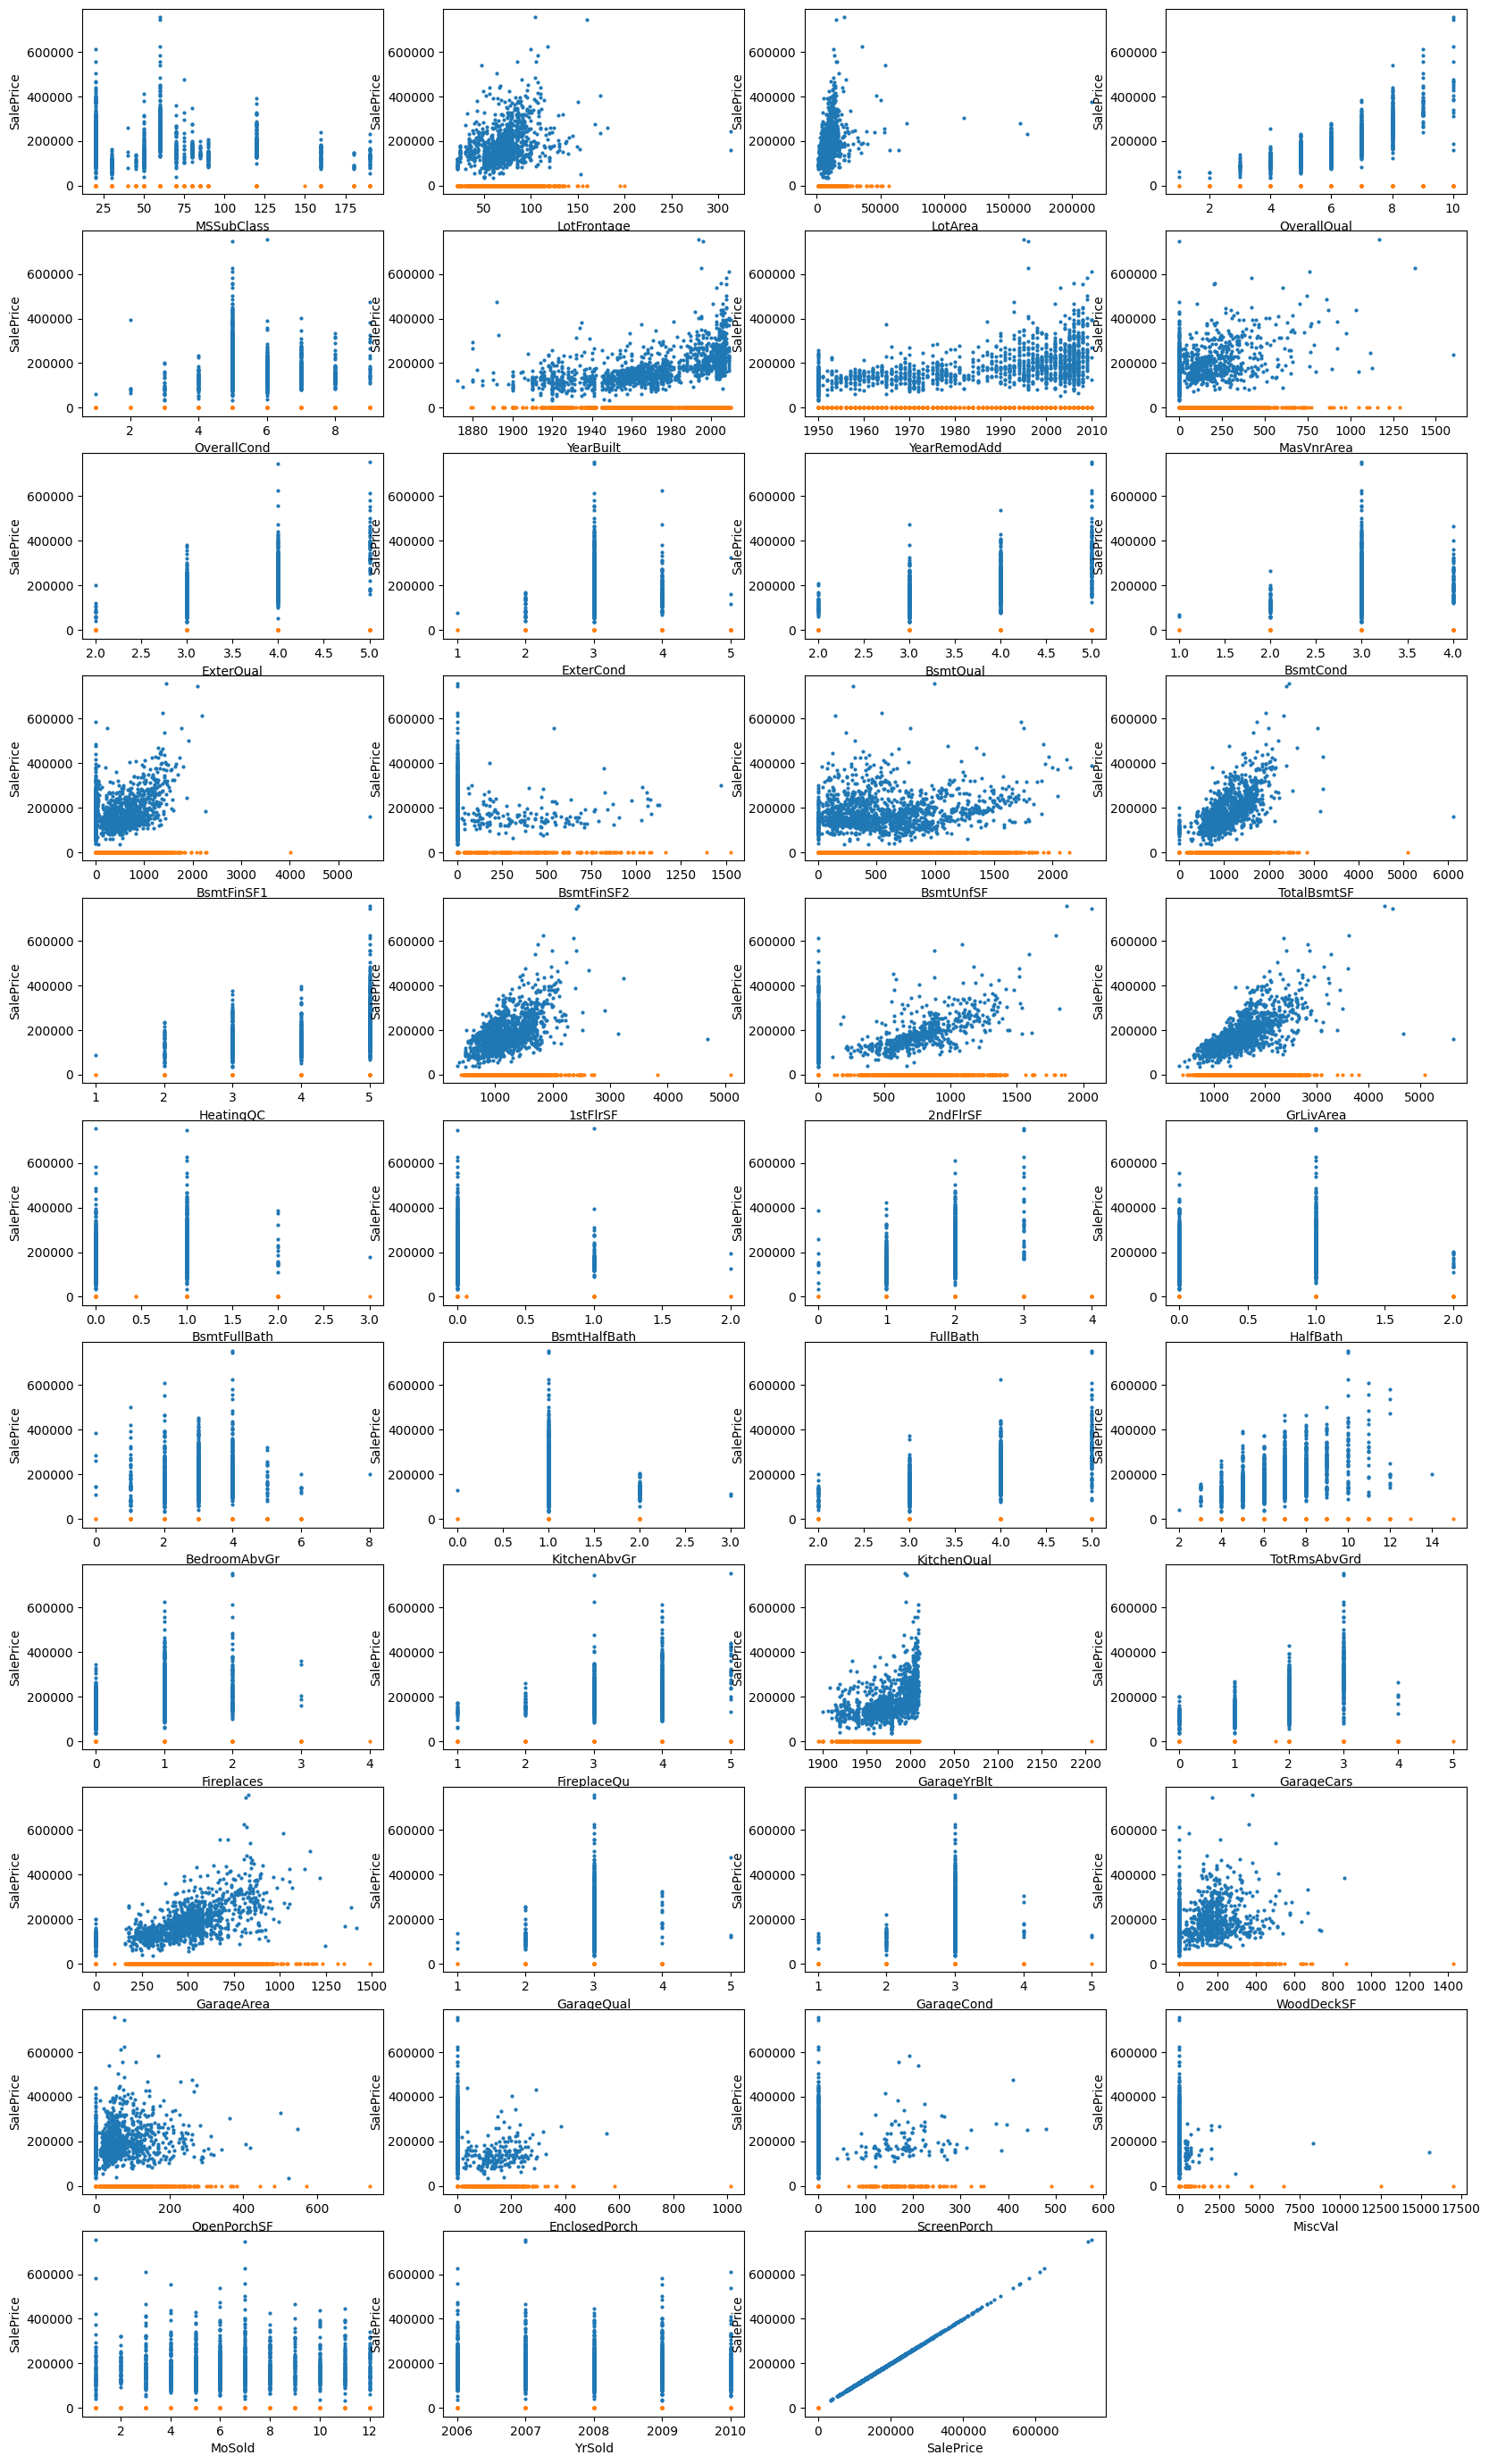

In [268]:
plt.figure(figsize = (20, 35))

for i, col in enumerate(continuous_columns):
    plt.subplot(11, 4, i + 1)
    plt.scatter(train_df[col], train_df.SalePrice, s = 4)
    plt.scatter(test_df[col], test_df.SalePrice, s = 4)
    plt.xlabel(col)
    plt.ylabel('SalePrice')

plt.show()    

In [270]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 68 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   LotShape       1460 non-null   object 
 5   LandContour    1460 non-null   object 
 6   LotConfig      1460 non-null   object 
 7   LandSlope      1460 non-null   object 
 8   Neighborhood   1460 non-null   object 
 9   Condition1     1460 non-null   object 
 10  BldgType       1460 non-null   object 
 11  HouseStyle     1460 non-null   object 
 12  OverallQual    1460 non-null   int64  
 13  OverallCond    1460 non-null   int64  
 14  YearBuilt      1460 non-null   int64  
 15  YearRemodAdd   1460 non-null   int64  
 16  RoofStyle      1460 non-null   object 
 17  Exterior1st    1460 non-null   object 
 18  Exterior

In [271]:
train_df.drop(columns = 'Id', inplace = True)
test_df.drop(columns = 'Id', inplace = True)

KeyError: ignored

Очистим от явных выбросов

In [ ]:
train_df = train_df.loc[
    (train_df.LotFrontage <= 200)
    (train_df.LotArea <= 100000) & 
    (train_df.YearBuilt >= 1900) & 
    (train_df.MasVnrArea <= 1000) & 
    (train_df.BsmtFinSF1 <= 5000) & 
    (train_df.BsmtFullBath <= 1) & 
    (train_df.FullBath <= 2) & 
    (train_df.BedroomAbvGr <= 4) & 
    (train_df.SalePrice <= 500000)
]

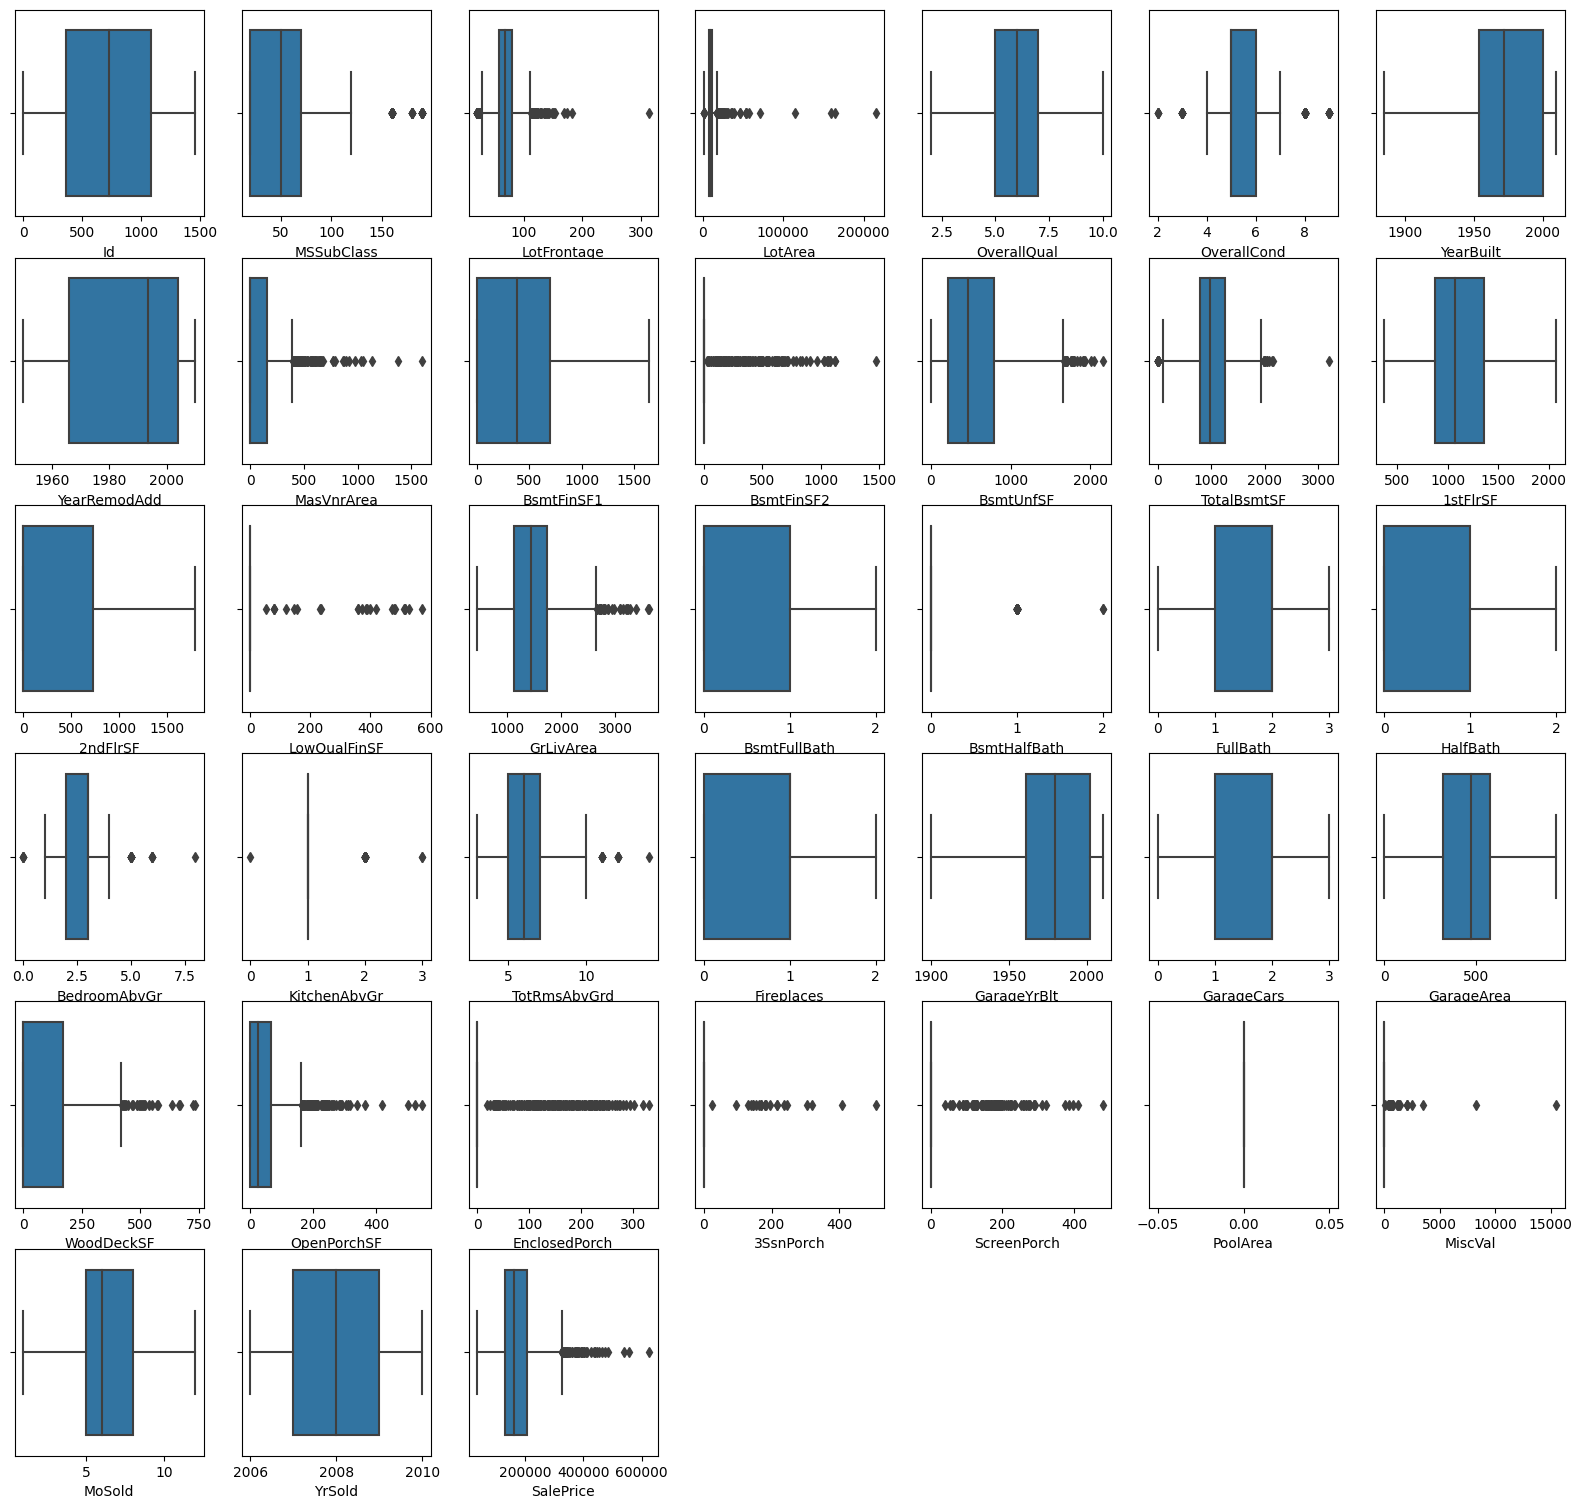

In [ ]:
plt.figure(figsize = (20, 22))
for i, col in enumerate(continuous_columns):
    plt.subplot(7, 7, i + 1)
    sns.boxplot(data = train_df, x = train_df[col])

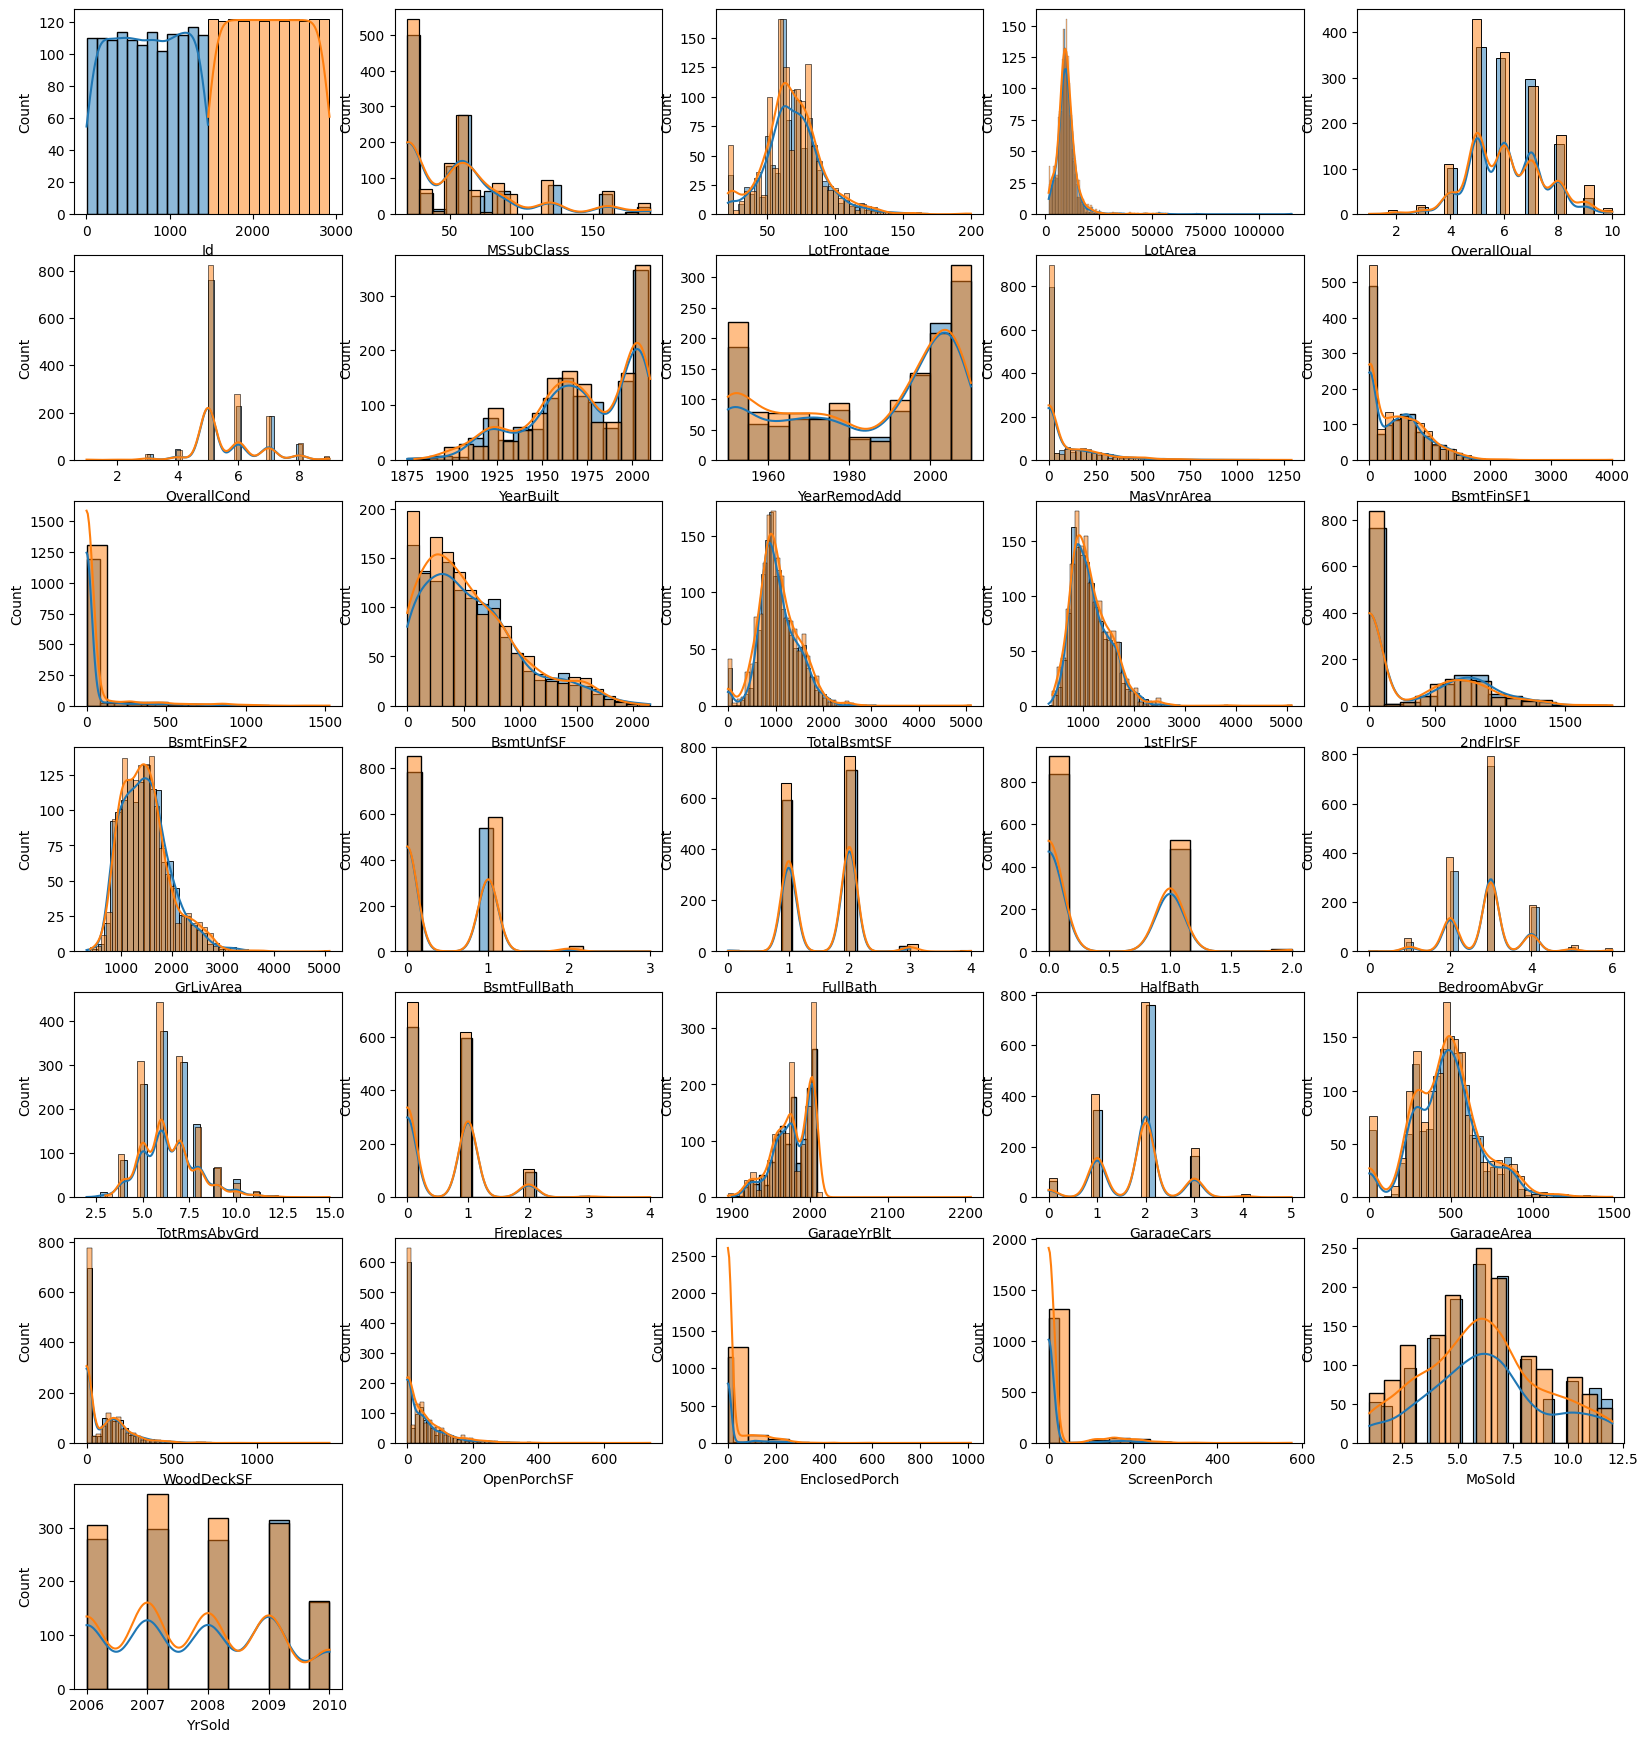

In [ ]:
plt.figure(figsize = (20, 25))

for i, col in enumerate(continuous_columns):
    plt.subplot(8, 5, i + 1)
    sns.histplot(data = train_df, x = train_df[col], kde = True, alpha = 0.5)
    sns.histplot(data = test_df, x = test_df[col], kde = True, alpha = 0.5)

In [ ]:
train_df = train_df.loc[(train_df.LotArea <= 50000) & (train_df.YearBuilt >= 1900) & (train_df.MasVnrArea <= 500) & \
                        (train_df.BsmtFinSF2 <= 1000) & (train_df.BsmtFullBath <= 1) & (train_df.FullBath <= 2) & (train_df.BedroomAbvGr <= 4) & (train_df.SalePrice <= 500000)]

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1221 entries, 0 to 1326
Data columns (total 63 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1221 non-null   int64  
 1   MSSubClass     1221 non-null   int64  
 2   MSZoning       1221 non-null   object 
 3   LotFrontage    1008 non-null   float64
 4   LotArea        1221 non-null   int64  
 5   LotShape       1221 non-null   object 
 6   LandContour    1221 non-null   object 
 7   LotConfig      1221 non-null   object 
 8   Neighborhood   1221 non-null   object 
 9   Condition1     1221 non-null   object 
 10  BldgType       1221 non-null   object 
 11  HouseStyle     1221 non-null   object 
 12  OverallQual    1221 non-null   int64  
 13  OverallCond    1221 non-null   int64  
 14  YearBuilt      1221 non-null   int64  
 15  YearRemodAdd   1221 non-null   int64  
 16  RoofStyle      1221 non-null   object 
 17  Exterior1st    1221 non-null   object 
 18  Exterior

In [ ]:
numeric_subset = train_df.select_dtypes('number')

for col in numeric_subset.columns:
    # Skip the Energy Star Score column
    if col == 'SalePrice':
        next
    else:
        numeric_subset['log_' + col] = np.log(numeric_subset[col] + 1e-5)
        
categorical_subset = train_df.select_dtypes('object')
# One-hot 
categorical_subset = pd.get_dummies(categorical_subset)

train_df = pd.concat([numeric_subset, categorical_subset], axis = 1)

In [ ]:
train_df, dropped_columns = remove_collinear_features(train_df, 0.65, True, target_var = 'SalePrice')

1stFlrSF | TotalBsmtSF | 0.79
1stFlrSF: 0.596
TotalBsmtSF: 0.624
dropped: 1stFlrSF
-----------------------------------------------------------------------------
GrLivArea | 2ndFlrSF | 0.65
GrLivArea: 0.725
2ndFlrSF: 0.269
dropped: 2ndFlrSF
-----------------------------------------------------------------------------
HalfBath | 2ndFlrSF | 0.68
HalfBath: 0.291
2ndFlrSF: 0.269
dropped: 2ndFlrSF
-----------------------------------------------------------------------------
TotRmsAbvGrd | GrLivArea | 0.82
TotRmsAbvGrd: 0.55
GrLivArea: 0.725
dropped: TotRmsAbvGrd
-----------------------------------------------------------------------------
TotRmsAbvGrd | BedroomAbvGr | 0.66
TotRmsAbvGrd: 0.55
BedroomAbvGr: 0.193
dropped: BedroomAbvGr
-----------------------------------------------------------------------------
GarageYrBlt | YearBuilt | 0.81
GarageYrBlt: 0.518
YearBuilt: 0.604
dropped: GarageYrBlt
-----------------------------------------------------------------------------
GarageArea | Garage

In [ ]:
numeric_subset = test_df.select_dtypes('number')

for col in numeric_subset.columns:
    # Skip the Energy Star Score column
    if col == 'SalePrice':
        next
    else:
        numeric_subset['log_' + col] = np.log(numeric_subset[col] + 1e-5)
        

categorical_subset = test_df.select_dtypes('object')
# One-hot 
categorical_subset = pd.get_dummies(categorical_subset)

test_df = pd.concat([numeric_subset, categorical_subset], axis = 1)

In [ ]:
test_df.drop(columns = dropped_columns, inplace = True)

In [ ]:
def drop_different_columns(df1, df2, target_col):
    '''
    Description:
        Удаляет столбцы, которые есть только в одной из матриц признаков
    
    Args:
        df1, df2 (pd.DataFrame): матрицы признаков
        target_col (str): поле, которое не трогаем в df1
    
    Returns:
        df1, df2 (pd.DataFrame): обновленные матрицы признаков
    '''
    drop_from_df1 = list(set(df1.columns) - set(df2.columns))
    drop_from_df1.remove(target_col)
    drop_from_df2 = list(set(df2.columns) - set(df1.columns))


    df1.drop(columns = drop_from_df1, inplace = True)
    df2.drop(columns = drop_from_df2, inplace = True)

    return df1, df2

In [ ]:
train_df, test_df = drop_different_columns(train_df, test_df, target_col = 'SalePrice')

In [ ]:
train_df.describe()

,LotFrontage,LotArea,OverallQual,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,GrLivArea,BsmtFullBath,FullBath,GarageCars,WoodDeckSF,EnclosedPorch,ScreenPorch,MoSold,SalePrice,log_Id,log_OverallCond,log_BsmtUnfSF,log_TotalBsmtSF,log_HalfBath,log_BedroomAbvGr,log_Fireplaces,log_OpenPorchSF,log_YrSold,MSZoning_C (all),MSZoning_RH,MSZoning_RL,...,Functional_Mod,Functional_Sev,Functional_Typ,FireplaceQu_Ex,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_Po,FireplaceQu_TA,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageFinish_Fin,GarageFinish_RFn,GarageFinish_Unf,PavedDrive_P,PavedDrive_Y,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family
count,1008.000000,1221.000000,1221.000000,1221.000000,1221.000000,1221.000000,1221.000000,1221.000000,1221.000000,1221.000000,1221.000000,1221.000000,1221.000000,1221.000000,1221.000000,1221.000000,1221.000000,1221.000000,1221.000000,1221.000000,1221.000000,1221.000000,1221.000000,1221.000000,1221.000000,1221.000000,1221.000000,1221.000000,1221.000000,1221.000000,...,1221.000000,1221.000000,1221.000000,1221.000000,1221.000000,1221.000000,1221.000000,1221.000000,1221.000000,1221.000000,1221.000000,1221.000000,1221.000000,1221.000000,1221.000000,1221.000000,1221.000000,1221.000000,1221.000000,1221.000000,1221.000000,1221.000000,1221.000000,1221.000000,1221.000000,1221.000000,1221.000000,1221.000000,1221.000000,1221.000000
mean,68.696429,9552.531532,6.042588,1972.552007,1984.890254,78.135788,423.320229,565.169533,1026.895168,1440.437346,0.406224,1.529075,1.744472,88.555283,20.475839,12.968059,6.294840,173345.143325,6.302098,1.702689,4.805124,6.437023,-7.342991,0.981136,-5.603551,-2.989919,7.604814,0.005733,0.008190,0.798526,...,0.008190,0.000819,0.935299,0.012285,0.024570,0.251433,0.014742,0.206388,0.000819,0.660934,0.013104,0.052416,0.004914,0.232596,0.301392,0.466011,0.020475,0.926290,0.032760,0.002457,0.000819,0.004914,0.003276,0.003276,0.080262,0.001638,0.063882,0.001638,0.004095,0.011466
std,20.593409,3885.724201,1.300626,28.922592,20.834109,121.318513,406.703749,428.369497,380.973245,429.794181,0.491329,0.502631,0.702615,116.383747,56.169799,48.581027,2.705165,65258.659115,0.969052,0.183009,4.749844,2.917850,5.538291,0.577264,5.803914,7.813255,0.000661,0.075530,0.090164,0.401266,...,0.090164,0.028618,0.246098,0.110200,0.154874,0.434015,0.120568,0.404878,0.028618,0.473586,0.113767,0.222956,0.069956,0.422660,0.459051,0.499048,0.141677,0.261406,0.178081,0.049528,0.028618,0.069956,0.057166,0.057166,0.271810,0.040456,0.244643,0.040456,0.063887,0.106507
min,21.000000,1526.000000,1.000000,1900.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,35311.000000,0.000010,1.098616,-11.512925,-11.512925,-11.512925,-11.512925,-11.512925,-11.512925,7.603898,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,59.000000,7472.000000,5.000000,1954.000000,1966.000000,0.000000,0.000000,239.000000,796.000000,1112.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,5.000000,129500.000000,5.913503,1.609440,5.476464,6.679599,-11.512925,0.693152,-11.512925,-11.512925,7.604396,0.000000,0.000000,1.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,69.000000,9247.000000,6.000000,1974.000000,1994.000000,0.000000,384.000000,484.000000,972.000000,1416.000000

In [ ]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Columns: 182 entries, LotFrontage to SaleCondition_Family
dtypes: float64(16), int64(10), uint8(156)
memory usage: 518.8 KB


In [ ]:
def print_missing_percent(df, threshold):
    '''
    Description:
        Выводит все поля, где пропущен какой-то процент значений

    Args:
        df (pd.DataFrame): матрица признаков
        threshold (float): порог отсечения между автозаполненными признаками и нет

    Returns:
        missing_list (list): массив пропущенных значений меньше порога threshold
    '''
    missing_list = []
    for col in df.columns:
        missing_count = df[col].isna().sum()
        total_count = df[col].count() + missing_count
        missing_percent = missing_count / total_count * 100
        if missing_percent:
            if missing_percent < threshold:
                missing_list.append(col)
            print(f"Column {col}: {missing_percent:.2f}%   missing values,  type: {df[col].dtype}")
    return missing_list

missing_list_train = print_missing_percent(df = train_df, threshold = 10)
print('#==================================================================#')
missing_list_test = print_missing_percent(df = test_df, threshold = 10)

Column LotFrontage: 17.44%   missing values,  type: float64
#==================================================================#
Column LotFrontage: 15.56%   missing values,  type: float64


In [ ]:
def smart_filling_missing(df, column):
    '''
    Description:
        Заполняет пропуски в столбце, где пропущено значительное число значений
    
    Args:
        df (pd.DataFrame): матрица признаков
        column (str): столбец с пропусками

    Returns:
        predictions (list): список пропусков в столбце в порядке индексов
    '''
    X_train = df.loc[df[column].notna()]
    y_train = X_train[column]
    X_train = X_train.drop(columns = [column])

    X_test = df.loc[df[column].isna()]
    X_test = X_test.drop(columns = [column])


    model = GradientBoostingRegressor()
    model.fit(X_train, y_train)

    predictions = model.predict(X_test)

    return predictions

In [ ]:
LotFrontageNans_train = smart_filling_missing(train_df, 'LotFrontage')
train_df.loc[train_df.LotFrontage.isna(), ['LotFrontage']] = LotFrontageNans_train

In [ ]:
LotFrontageNans_test = smart_filling_missing(test_df, 'LotFrontage')
test_df.loc[test_df.LotFrontage.isna(), ['LotFrontage']] = LotFrontageNans_test

In [ ]:
def plot_missed_values_column(col, col_fill):
    '''
    Description:
        Рисует scatter-plot двух колонок, одну из которых дополнили

    Args:
        col (str): название колонки
        col_fill (str): название колонки, которую заполнили
    '''

    

In [ ]:
train_df.to_csv('train_clear.csv', index = False)

In [ ]:
test_df.to_csv('test_clear.csv', index = False)